# Importing libraries

In [16]:
import glob
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Model,Input

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
from system_usage_dec import monitor_performance

### Loading and pre-processing the data

In [17]:
train_image = []
train_annotation = []

image_file = glob.glob("drone_dataset_yolo\dataset_txt\*.jpg")

for i in image_file:     #slicing for insufficient memory
    Load_image = Image.open(i).convert('RGB')
    nmpy_img = Load_image.resize((256, 256))
    train_image.append(np.asarray(nmpy_img))
    
    seperate_path = i.split('.')
    seperate_path[1] = '.txt'
    
    with open(seperate_path[0]+seperate_path[1]) as f:
        lines = f.readlines()
        tmp_lst = lines[0].split(' ')
        #label = int(tmp_lst[0])
        startX = float(tmp_lst[1])
        startY = float(tmp_lst[2])
        endX = float(tmp_lst[3])
        endY = float(tmp_lst[4])
        train_annotation.append((startX, startY, endX, endY))

### Displaying sample images

1359


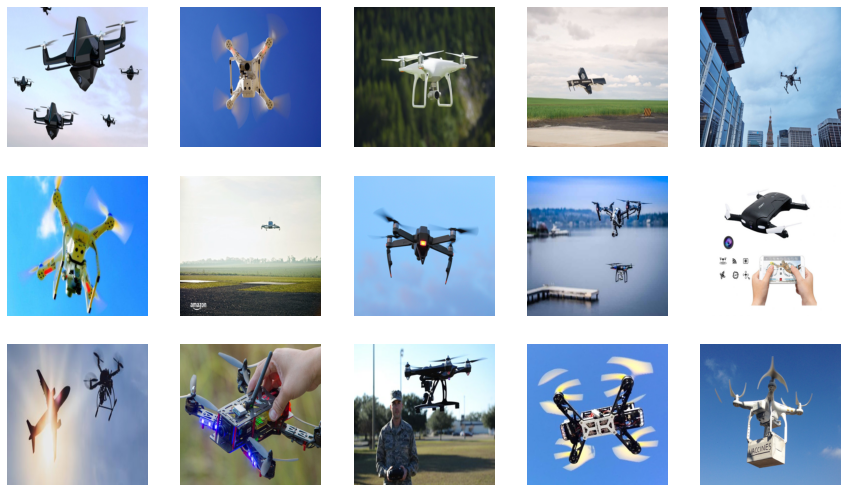

In [18]:
print(len(train_image))

plt.figure(figsize=(15, 15))

for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(train_image[i].astype("uint8"))
    plt.axis("off")

### Splitting the data into training and testing sets

In [19]:
from sklearn.model_selection import train_test_split
data = np.array(train_image, dtype='float32') / 255.0   # memory not sufficient !!
targets = np.array(train_annotation, dtype='float32')

split = train_test_split(data, targets, test_size=0.10, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

# Printing the shapes of the data and targets arrays

data.shape, targets.shape

((1359, 256, 256, 3), (1359, 4))

# Augmentation

In [20]:
def random_horizontal_flip(image, bbox):
    if np.random.rand() < 0.5:
        image = np.fliplr(image)
        bbox[0] = 1 - bbox[0]  # Update x-center for flip
    return image, bbox.astype(np.float32)



def random_rotate(image, bbox, max_angle=30):
    angle = np.random.uniform(-max_angle, max_angle)
    angle_rad = np.deg2rad(angle)
    
    image_rot = tf.keras.preprocessing.image.random_rotation(image, max_angle, row_axis=0, col_axis=1, channel_axis=2)
    
    def rotate_box(box, angle_rad, image_shape):
        x_center, y_center, width, height = box
        cos_angle = np.cos(angle_rad)
        sin_angle = np.sin(angle_rad)
        
        x_center_new = cos_angle * (x_center - 0.5) - sin_angle * (y_center - 0.5) + 0.5
        y_center_new = sin_angle * (x_center - 0.5) + cos_angle * (y_center - 0.5) + 0.5
        
        return np.array([x_center_new, y_center_new, width, height], dtype=np.float32)
    
    bbox_rot = rotate_box(bbox, angle_rad, image.shape)
    
    return image_rot, bbox_rot

In [29]:
def augment_image(image, bbox):
    image, bbox = random_horizontal_flip(image, bbox)
    image, bbox = random_rotate(image, bbox)
    return image.astype(np.float32), bbox.astype(np.float32)

In [28]:
def preprocess(image, bbox):
    image, bbox = tf.numpy_function(augment_image, [image, bbox], [tf.float32, tf.float32])
    image.set_shape((None, None, 3))
    bbox.set_shape((4,))
    return image, bbox

def load_dataset(images, bboxes, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, bboxes))
    if augment:
        dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [30]:
train_images, val_images, train_bboxes, val_bboxes = train_test_split(trainImages, trainTargets, test_size=0.2, random_state=42)

train_dataset = load_dataset(train_images, train_bboxes, augment=True)
val_dataset = load_dataset(val_images, val_bboxes, augment=False)

batch_size = 16
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# VGG16

### Building model

In [31]:
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Model,Input

def build_vggmodel():
    vgg = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))

    vgg.trainable = False

    flatten = vgg.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(128, activation="relu")(flatten)
    bboxHead = Dense(64, activation="relu")(bboxHead)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(4, activation="linear")(bboxHead)

    vggmodel = Model(inputs=vgg.input, outputs=bboxHead)
    
    return vggmodel

vggmodel = build_vggmodel()

vggmodel.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

## Compiling and training the model

In [7]:
@monitor_performance(f'CNN_results/VGG_memory_usage')
def train_model():
    global vggmodel, trainImages,  trainTargets
    global train_images
    vggmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

    save_best = tf.keras.callbacks.ModelCheckpoint("VGGModel.h5.keras",monitor='val_loss',save_best_only=True, verbose=1)

    historyvgg = vggmodel.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,
        verbose=1,
        callbacks=[save_best]
    )
    return historyvgg

In [8]:
historyvgg = train_model()

Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 0.2909 - accuracy: 0.5378
Epoch 1: val_loss improved from inf to 0.07137, saving model to VGGModel.h5.keras
62/62 [==============================] - 32s 454ms/step - loss: 0.2909 - accuracy: 0.5378 - val_loss: 0.0714 - val_accuracy: 0.6082
Epoch 2/10
62/62 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.6462
Epoch 2: val_loss improved from 0.07137 to 0.03269, saving model to VGGModel.h5.keras
62/62 [==============================] - 25s 409ms/step - loss: 0.0352 - accuracy: 0.6462 - val_loss: 0.0327 - val_accuracy: 0.6082
Epoch 3/10
62/62 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.6401
Epoch 3: val_loss improved from 0.03269 to 0.02771, saving model to VGGModel.h5.keras
62/62 [==============================] - 25s 404ms/step - loss: 0.0294 - accuracy: 0.6401 - val_loss: 0.0277 - val_accuracy: 0.6000
Epoch 4/10
62/62 [==============================] - ETA: 0s - loss: 

### Predictions on test images

In [10]:
vggmodel = tf.keras.models.load_model('VGGModel.h5.keras')

vggmodel.predict(testImages[:10], verbose=1)

1/1 [==============================] - 0s 87ms/step


array([[0.52168053, 0.5436383 , 1.0324217 , 0.5827991 ],
       [0.5166895 , 0.5690683 , 0.84871113, 0.5782591 ],
       [0.5064107 , 0.45410845, 0.7514801 , 0.43641606],
       [0.5151761 , 0.5388471 , 0.90476745, 0.66513   ],
       [0.5873425 , 0.46332806, 0.735072  , 0.5225388 ],
       [0.5520129 , 0.4104029 , 0.777829  , 0.5043644 ],
       [0.47632658, 0.33648568, 0.73591256, 0.46704936],
       [0.4861671 , 0.387695  , 0.8121645 , 0.6103542 ],
       [0.4985878 , 0.5000966 , 0.76283455, 0.5505896 ],
       [0.53931814, 0.4978598 , 1.0438468 , 0.5346738 ]], dtype=float32)

### Performance

#### Acccuracy vs No. of epochs graph

Final Training Accuracy: 0.6922290325164795
Final Validation Accuracy: 0.6489796042442322


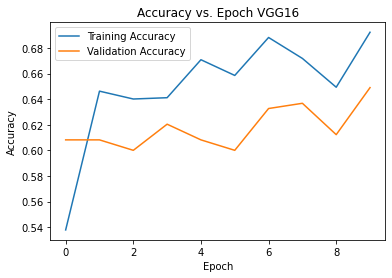

In [11]:
print('Final Training Accuracy:', historyvgg.history['accuracy'][-1])
print('Final Validation Accuracy:', historyvgg.history['val_accuracy'][-1])

plt.plot(historyvgg.history['accuracy'], label='Training Accuracy')
plt.plot(historyvgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch VGG16')
plt.legend()
plt.show()

#### Loss vs No. of epochs graph

Final Training Loss: 0.021394159644842148
Final Validation Loss: 0.022932227700948715


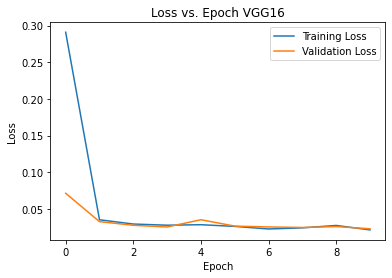

In [12]:
print('Final Training Loss:', historyvgg.history['loss'][-1])
print('Final Validation Loss:', historyvgg.history['val_loss'][-1])

plt.plot(historyvgg.history['loss'], label='Training Loss')
plt.plot(historyvgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch VGG16')
plt.legend()
plt.show()

### Evaluating on test images

In [13]:
loss, accuracy = vggmodel.evaluate(testImages, testTargets, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 [==============================] - 4s 435ms/step - loss: 0.0266 - accuracy: 0.6838
Test Loss: 0.026627067476511
Test Accuracy: 0.6838235259056091


# Resnet50

### Building model

In [5]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model, Input

def build_resnetmodel():
    resnet = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))

    resnet.trainable = True

    flatten = resnet.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(128, activation="relu")(flatten)
    bboxHead = Dense(64, activation="relu")(bboxHead)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(4, activation="linear")(bboxHead)

    resnetmodel = Model(inputs=resnet.input, outputs=bboxHead)
    
    return resnetmodel

resnetmodel = build_resnetmodel()

resnetmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### Compiling and training the model

In [10]:
@monitor_performance(f'CNN_results/ResNet_memory_usage')
def train_model():
    global resnetmodel, trainImages,  trainTargets
    global train_images
    resnetmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

    save_best = tf.keras.callbacks.ModelCheckpoint("RESNETModel.h5", verbose=1)

    historyresnet= resnetmodel.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,
        verbose=1,
        callbacks=[save_best])
    return historyresnet

In [11]:
historyresnet = train_model()

Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.5297
Epoch 1: saving model to RESNETModel.h5
62/62 [==============================] - 25s 357ms/step - loss: 0.1026 - accuracy: 0.5297 - val_loss: 250.0316 - val_accuracy: 0.6082
Epoch 2/10
62/62 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.6616
Epoch 2: saving model to RESNETModel.h5
62/62 [==============================] - 22s 348ms/step - loss: 0.0281 - accuracy: 0.6616 - val_loss: 3.5094 - val_accuracy: 0.1265
Epoch 3/10
62/62 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.7076
Epoch 3: saving model to RESNETModel.h5
62/62 [==============================] - 21s 342ms/step - loss: 0.0223 - accuracy: 0.7076 - val_loss: 0.1280 - val_accuracy: 0.1592
Epoch 4/10
62/62 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.7628
Epoch 4: saving model to RESNETModel.h5
62/62 [==============================] - 23s 366ms/step - loss: 0.

### Predictions on test images

In [8]:
resnetmodel = tf.keras.models.load_model('./RESNETModel.h5')

resnetmodel.predict(testImages[:10], verbose=1)

1/1 [==============================] - 1s 942ms/step


array([[0.54692763, 0.4255332 , 0.55167437, 0.25521842],
       [0.46825287, 0.4253972 , 0.21392669, 0.07524916],
       [0.49049243, 0.45168164, 0.21366526, 0.08344271],
       [0.5028232 , 0.42549863, 0.28044605, 0.2638935 ],
       [0.46277645, 0.39447513, 0.1993816 , 0.12285169],
       [0.4580774 , 0.42177323, 0.2765205 , 0.19506511],
       [0.4722844 , 0.45909038, 0.14865555, 0.03905114],
       [0.48175856, 0.40488878, 0.22903039, 0.14466915],
       [0.46261063, 0.38688853, 0.1757151 , 0.05569466],
       [0.55020106, 0.3788443 , 0.6681659 , 0.4177241 ]], dtype=float32)

### Performance

#### Acccuracy vs No. of epochs graph

Final Training Accuracy: 0.8711656332015991
Final Validation Accuracy: 0.8122448921203613


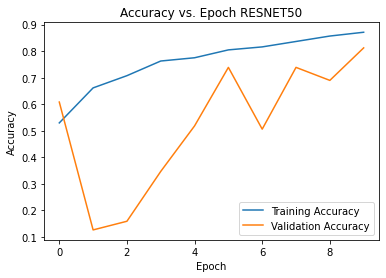

In [12]:
print('Final Training Accuracy:', historyresnet.history['accuracy'][-1])
print('Final Validation Accuracy:', historyresnet.history['val_accuracy'][-1])

plt.plot(historyresnet.history['accuracy'], label='Training Accuracy')
plt.plot(historyresnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch RESNET50')
plt.legend()
plt.show()

#### Loss vs No. of epochs graph

Final Training Loss: 0.004734368529170752
Final Validation Loss: 0.01925770379602909


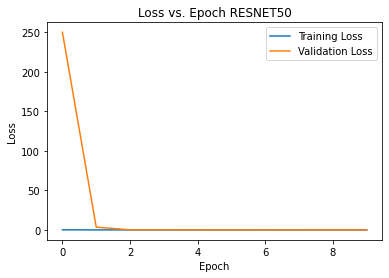

In [13]:
print('Final Training Loss:', historyresnet.history['loss'][-1])
print('Final Validation Loss:', historyresnet.history['val_loss'][-1])

plt.plot(historyresnet.history['loss'], label='Training Loss')
plt.plot(historyresnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch RESNET50')
plt.legend()
plt.show()

### Evaluating on test images

In [14]:
loss, accuracy = resnetmodel.evaluate(testImages, testTargets, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 [==============================] - 2s 216ms/step - loss: 0.0214 - accuracy: 0.7794
Test Loss: 0.021364247426390648
Test Accuracy: 0.779411792755127
